# Intrusion detection in UNSW using NetTiSA flows

In [1]:
import pandas as pd
import numpy as np
import json
import collections

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import seaborn as sns

#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
import catboost as cb

# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

from sklearn.model_selection import train_test_split


In [8]:
df = pd.read_csv("../final_datasets/unsw_binary.csv")

In [9]:
df.head()

,Unnamed: 0,DST_IP,SRC_IP,PACKETS,PACKETS_REV,BYTES,BYTES_REV,TIME_FIRST,TIME_LAST,AVERAGE_DISPERSION,...,MAX,MIN,MIN_MINUS_MAX,PERCENT_DEVIATION,VARIANCE,BURTINESS,COEFFICIENT_OF_VARIATION,DIRECTIONS,DURATION,LABEL
0,0,149.171.126.18,175.45.176.0,10,8,938,336,2015-02-18T00:23:58.808907,2015-02-18T00:23:59.345359,49.904728,...,253,0,253,1.775267,6328.110700,0.477782,2.829821,0.555556,0.536452,Exploits
1,1,149.171.126.16,175.45.176.3,14,38,710,42002,2015-02-18T00:23:27.658518,2015-02-18T00:23:28.308420,607.387329,...,1460,0,1460,0.777322,489890.374932,-0.054994,0.895746,0.269231,0.649902,Clear
2,2,149.171.126.18,175.45.176.3,10,6,986,256,2015-02-18T00:23:36.650797,2015-02-18T00:23:36.988814,57.267792,...,277,0,277,1.653943,8435.124526,0.452430,2.652503,0.625000,0.338017,Clear
3,3,149.171.126.14,175.45.176.3,2,0,1200,0,2015-02-18T00:24:29.943387,2015-02-18T00:24:29.943398,286.000000,...,572,572,0,0.500000,0.000000,-1.000000,0.000000,1.000000,0.000011,Clear
4,4,149.171.126.14,175.45.176.3,2,0,942,0,2015-02-18T00:24:32.662918,2015-02-18T00:24:32.662929,221.500000,...,443,443,0,0.500000,0.000000,-1.000000,0.000000,1.000000,0.000011,Clear


In [9]:
features = [
        'PACKETS', 
        'PACKETS_REV', 
        'BYTES',
        'BYTES_REV',
        'AVERAGE_DISPERSION', 
        'KURTOSIS',
        'MAX_DIFFTIMES', 
        'MEAN', 
        'MEAN_DIFFTIMES',
        'MEAN_SCALED_TIME', 
        'MIN_DIFFTIMES',
        'ROOT_MEAN_SQUARE', 
        'STDEV',
        'SWITCHING_RATIO', 
        'TIME_DISTRIBUTION',
        'MAX', 
        'MIN', 
        'MIN_MINUS_MAX',
        'PERCENT_DEVIATION', 
        'VARIANCE',
        'BURTINESS', 
        'COEFFICIENT_OF_VARIATION',
        'DIRECTIONS', 
        'DURATION', 
]

In [10]:
import sklearn
pd.set_option('display.max_columns', None)

df = df[["LABEL"] + features].copy()

df['LABEL'] = df.LABEL.astype('category')
df["LABEL_code"] = df["LABEL"].cat.codes


# for F in features:
#     df.replace([np.inf], 0, inplace=True)
#     df.replace([-np.inf], 0, inplace=True)
#     df.loc[df[F].isnull(), F] = 0

In [11]:
df

,LABEL,PACKETS,PACKETS_REV,BYTES,BYTES_REV,AVERAGE_DISPERSION,KURTOSIS,MAX_DIFFTIMES,MEAN,MEAN_DIFFTIMES,MEAN_SCALED_TIME,MIN_DIFFTIMES,ROOT_MEAN_SQUARE,STDEV,SWITCHING_RATIO,TIME_DISTRIBUTION,MAX,MIN,MIN_MINUS_MAX,PERCENT_DEVIATION,VARIANCE,BURTINESS,COEFFICIENT_OF_VARIATION,DIRECTIONS,DURATION,LABEL_code
0,Exploits,10,8,938,336,49.904728,8.817814,259993.0,28.111111,29802.888672,3.039079e+05,0.0,84.333336,79.549423,0.666667,0.145633,253,0,253,1.775267,6328.110700,0.477782,2.829821,0.555556,0.536452,4
1,Clear,14,38,710,42002,607.387329,1.939034,118119.0,781.384521,12498.114258,3.837693e+05,0.0,1048.738037,699.921692,0.403846,0.181585,1460,0,1460,0.777322,489890.374932,-0.054994,0.895746,0.269231,0.649902,2
2,Clear,10,6,986,256,57.267792,8.020354,99324.0,34.625004,21126.062500,2.010252e+05,0.0,97.934288,91.842934,0.625000,0.232682,277,0,277,1.653943,8435.124526,0.452430,2.652503,0.625000,0.338017,2
3,Clear,2,0,1200,0,286.000000,0.000000,11.0,572.000000,5.500000,5.500000e+00,0.0,572.000000,0.000000,0.500000,-0.009804,572,572,0,0.500000,0.000000,-1.000000,0.000000,1.000000,0.000011,2
4,Clear,2,0,942,0,221.500000,0.000000,11.0,443.000000,5.500000,5.500000e+00,0.0,443.000000,0.000000,0.500000,-0.012731,443,443,0,0.500000,0.000000,-1.000000,0.000000,1.000000,0.000011,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1953400,Clear,52,42,37310,3380,422.438446,3.379862,84310.0,380.702209,6859.926758,2.871488e+05,0.0,725.660767,618.209961,0.393617,0.115638,1448,0,1448,1.109630,382183.555880,0.237766,1.623868,0.553191,0.644833,2
1953401,Clear,36,34,2044,2404,12.384136,4.107973,623250.0,11.314287,25978.988281,1.108748e+06,0.0,20.021418,16.728931,0.485714,0.073118,54,0,54,1.094557,279.857132,0.193082,1.478567,0.514286,1.818529,2
1953402,Clear,54,56,3302,40550,365.320526,3.433541,1748.0,346.509064,190.309097,8.214510e+03,0.0,650.926758,551.352539,0.454545,0.114844,1300,0,1300,1.054289,303989.622262,0.228146,1.591163,0.490909,0.020934,2
1953403,Clear,54,56,3302,40550,365.320526,3.433541,2807.0,346.509064,215.936325,9.588800e+03,0.0,650.926758,551.352539,0.454545,0.083934,1300,0,1300,1.054289,303989.622262,0.228146,1.591163,0.490909,0.023753,2


In [8]:
df[df.LABEL == 'Clear'][['LABEL', 'LABEL_code']].head(1)

,LABEL,LABEL_code
1,Clear,2


In [9]:
df = df[["LABEL_code"] + features].copy()

In [10]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

df = clean_dataset(df)

In [11]:
X = df[features]
y = df.LABEL_code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y) # 70% training and 30% test

X_train['LABEL_code'] = y_train
df_features = X_train

X_test['LABEL_code'] = y_test
df_validation = X_test

# df_validation = df.sample(n=1000000)
# df_features =  df[~df.isin(df_validation)].dropna()

In [12]:
df_features.LABEL_code.value_counts()

2.0    1315683
4.0      16164
5.0      13124
7.0       7691
1.0       4532
6.0       2561
3.0       2320
8.0        969
0.0        234
9.0        108
Name: LABEL_code, dtype: int64

In [13]:
df_features.LABEL_code.mask(df_features.LABEL_code == 2, -1, inplace=True)
df_features.LABEL_code.mask(df_features.LABEL_code != -1, 1, inplace=True)
df_features.LABEL_code.mask(df_features.LABEL_code == -1, 0, inplace=True)

df_validation.LABEL_code.mask(df_validation.LABEL_code == 2, -1, inplace=True)
df_validation.LABEL_code.mask(df_validation.LABEL_code != -1, 1, inplace=True)
df_validation.LABEL_code.mask(df_validation.LABEL_code == -1, 0, inplace=True)



In [14]:
df_features.LABEL_code.value_counts()

0.0    1315683
1.0      47703
Name: LABEL_code, dtype: int64

In [15]:
df_validation.LABEL_code.value_counts()

0.0    563865
1.0     20444
Name: LABEL_code, dtype: int64

In [16]:
# df_majority_class = df_features[df_features.LABEL_code == 0]
# df_minority_class = df_features[df_features.LABEL_code != 0]
# df_class_undersample = df_majority_class.sample(len(df_minority_class))
# df_features = pd.concat([df_class_undersample, df_minority_class], axis=0)

In [17]:
# df_features.LABEL_code.value_counts()

In [18]:
def get_confusion_matrix(y_test, y_pred):
    # Get and reshape confusion matrix data
    matrix = confusion_matrix(y_test, y_pred)
    percentage_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    return matrix, percentage_matrix

def plot_confusion_matrix(matrix, percentage_matrix, model=""):
    # Build the plot
    fig, ax = plt.subplots(1, 2,figsize=(15,5))
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10}, fmt='g',
                cmap=plt.cm.Greens, linewidths=0.2, ax=ax[0])
    sns.heatmap(percentage_matrix, annot=True, annot_kws={'size':10}, fmt='g',
                cmap=plt.cm.Greens, linewidths=0.2, ax=ax[1])
    # Add labels to the plot
    plt.tick_params(axis='both', which='minor', labelsize=5)
    # tick_marks = np.arange(len(classifications_array)) + 0.5
    # plt.xticks(tick_marks, classifications_array, rotation=85)
    # plt.yticks(tick_marks, classifications_array, rotation=0)
    ax[0].set_xlabel('Predicted label')
    ax[0].set_ylabel('True label')
    ax[0].set_title(f'Absolute Confusion Matrix for {model}')
    ax[1].set_xlabel('Predicted label')
    ax[1].set_ylabel('True label')
    ax[1].set_title(f'Relative Confusion Matrix for {model}')
    # pyplot.savefig("ddos_timeseries_plugin_classification.eps", format="eps")
    plt.show()

In [19]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_absolute_error

def tunne_together_XGBoost_classification(df_tunne, _features, verbose=True):
    X=df_tunne[_features]  # Features
    y=df_tunne['LABEL_code']  # Labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y)
    
    def objective(space):
        clf = XGBClassifier(
                        # tree_method="hist",
                        
                        base_score=float(space['base_score']),
                        n_estimators = int(space['n_estimators']), 
                        max_depth = int(space['max_depth']), 
                        gamma = space['gamma'],
                        reg_alpha = float(space['reg_alpha']),
                        min_child_weight=int(space['min_child_weight']),
                        reg_lambda = float(space['reg_lambda']),
                        colsample_bytree=float(space['colsample_bytree']), 
                        # subsample=float(space['subsample']),
                        # eta=space['eta'],
                            )

        evaluation = [( X_train, y_train), ( X_test, y_test)]

        clf.fit(X_train, y_train,
                eval_set=evaluation, eval_metric="auc",
                early_stopping_rounds=10,verbose=False)

        pred = clf.predict(X_test)
        # accuracy = mean_absolute_error(y_test, pred)
        # accuracy = accuracy_score(y_test, pred)
        accuracy = f1_score(y_test, pred)
        if verbose is True:
            print ("SCORE:", accuracy)
        return {'loss': -accuracy, 'status': STATUS_OK }
    
    space={'max_depth': hp.quniform("max_depth", 5, 50, 5),
        'gamma': hp.uniform ('gamma', 1,18),
        'reg_alpha' : hp.quniform('reg_alpha', 0,180,2),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 20, 1),
        'n_estimators': hp.quniform('n_estimators', 50, 300, 20),
        # 'subsample': hp.uniform('subsample', 0, 1),
        'base_score': hp.uniform('subsample', 0, 1),
        # 'eta': hp.quniform('eta', 0.005, 0.3, 0.005),
        'seed': 0
    }
    
    trials = Trials()
    
    best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)
        
    print("The best hyperparameters are : ","\n")
    print(best_hyperparams)
    return best_hyperparams

In [20]:
best_hyperparams = tunne_together_XGBoost_classification(df_features, features, verbose=False)

100%|██████████| 100/100 [2:02:15<00:00, 73.36s/trial, best loss: -0.8827116721032477]
The best hyperparameters are :  

{'colsample_bytree': 0.7304761442011863, 'gamma': 5.531179157477326, 'max_depth': 35.0, 'min_child_weight': 0.0, 'n_estimators': 160.0, 'reg_alpha': 2.0, 'reg_lambda': 0.30242290063245014, 'subsample': 0.4549453220211464}


In [21]:
def XGBoost_classification_tunned(best_hyperparams):
      X=df_features[features]  # Features
      y=df_features['LABEL_code']  # Labels
      #Split on train and test
      # X_train_a, X_test_a, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y) # 70% training and 30% test
      # X_train = X_train_a[features]
      # X_test = X_test_a[features] 
      
      # best_f1 = 0
      # best_model = None
      model = XGBClassifier(
            # tree_method="hist",
            
            # base_score=float(best_hyperparams['base_score']),
            n_estimators =  int(best_hyperparams['n_estimators']), 
            max_depth = int(best_hyperparams['max_depth']), 
            gamma = best_hyperparams['gamma'],
            reg_alpha = float(best_hyperparams['reg_alpha']),
            min_child_weight=int(best_hyperparams['min_child_weight']),
            reg_lambda = float(best_hyperparams['reg_lambda']),
            colsample_bytree=float(best_hyperparams['colsample_bytree']),
            # subsample=float(best_hyperparams['subsample']),
            # eta=best_hyperparams['eta'],
      )
      model.fit(X, y)
      return model
      # model.fit(X_train, y_train)
      # y_pred = model.predict(X_test)
      
      # accuracy = metrics.accuracy_score(y_test, y_pred)  * 100
      # precision = precision_score(y_test, y_pred)  * 100
      # recall = recall_score(y_test, y_pred)  * 100
      # F1 = f1_score(y_test, y_pred)  * 100
      # print("   {:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1))
      # if F1 > best_f1:
      #       best_f1  = F1
      #       best_model = model
      # matrix, percentage_matrix = get_confusion_matrix(y_test, y_pred)
      # plot_confusion_matrix(matrix, percentage_matrix, model="XGBoost")
      # return best_model

In [22]:
model = XGBoost_classification_tunned(best_hyperparams)

In [192]:
def while_XGBoost_classification_tunned(best_hyperparams, cycles=100):
    X=df_features[features]  # Features
    y=df_features['LABEL_code']  # Labels
    best_results = (0,"",None,None, None)
    for i in range(cycles):
        #Split on train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y) # 70% training and 30% test
        model = XGBClassifier(
          n_estimators =  int(best_hyperparams['n_estimators']), 
            max_depth = int(best_hyperparams['max_depth']), 
            gamma = best_hyperparams['gamma'],
            reg_alpha = float(best_hyperparams['reg_alpha']),
            min_child_weight=int(best_hyperparams['min_child_weight']),
            reg_lambda = float(best_hyperparams['reg_lambda']),
            colsample_bytree=float(best_hyperparams['colsample_bytree']),
          )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, y_pred)  * 100
        precision = precision_score(y_test, y_pred)  * 100
        recall = recall_score(y_test, y_pred)  * 100
        F1 = f1_score(y_test, y_pred)  * 100
        if best_results[0] < F1:
            matrix, percentage_matrix = get_confusion_matrix(y_test, y_pred)
            best_results = (F1, "{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1), matrix, percentage_matrix, model)
    print("")
    print("")
    print("")
    print(best_results[0])
    print(best_results[1])
    plot_confusion_matrix(best_results[2], best_results[3], model="XGBoost")
    return best_results[4]




88.41448452343394
99.19 & 88.71 & 88.12 & 88.41 \\


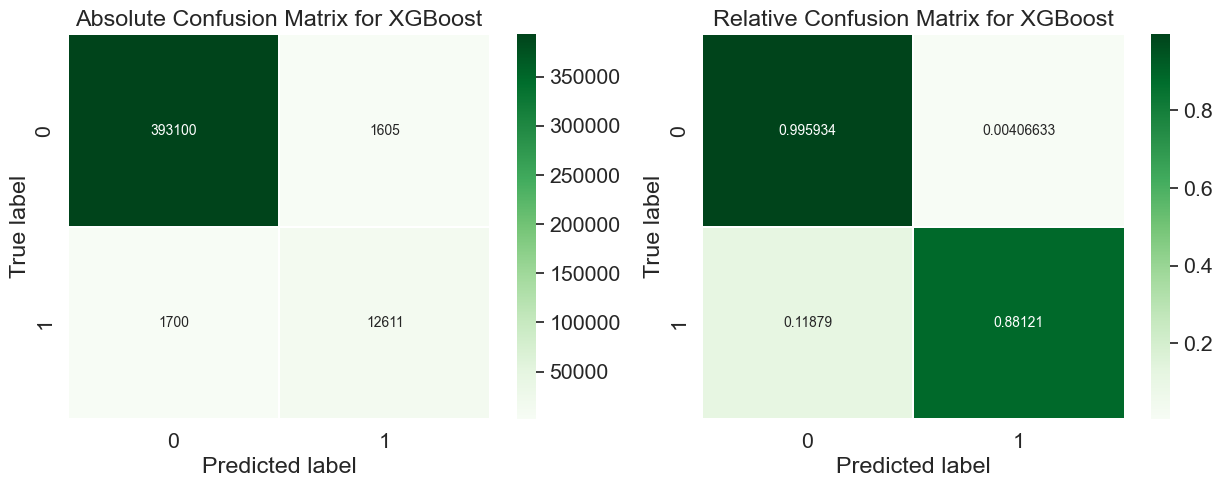

In [193]:
best_model = while_XGBoost_classification_tunned(best_hyperparams, cycles=10)

In [23]:
best_model = model

# Validation

99.22 & 89.55 & 87.98 & 88.76 \\


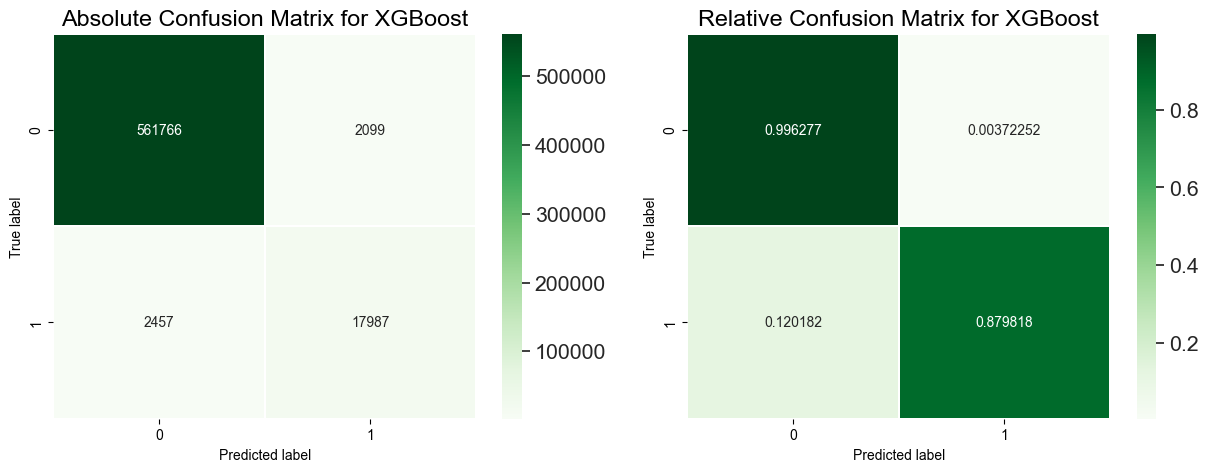

In [24]:
X_validation=df_validation[features]  # Features
y_validation=df_validation['LABEL_code']  # Labels
y_pred = best_model.predict(X_validation)
accuracy = metrics.accuracy_score(y_validation, y_pred)  * 100
precision = precision_score(y_validation, y_pred)  * 100
recall = recall_score(y_validation, y_pred)  * 100
F1 = f1_score(y_validation, y_pred)  * 100
                
tmp_str = "{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1)
print(tmp_str)

matrix, percentage_matrix = get_confusion_matrix(y_validation, y_pred)
plot_confusion_matrix(matrix, percentage_matrix, model="XGBoost")

# Feature importance

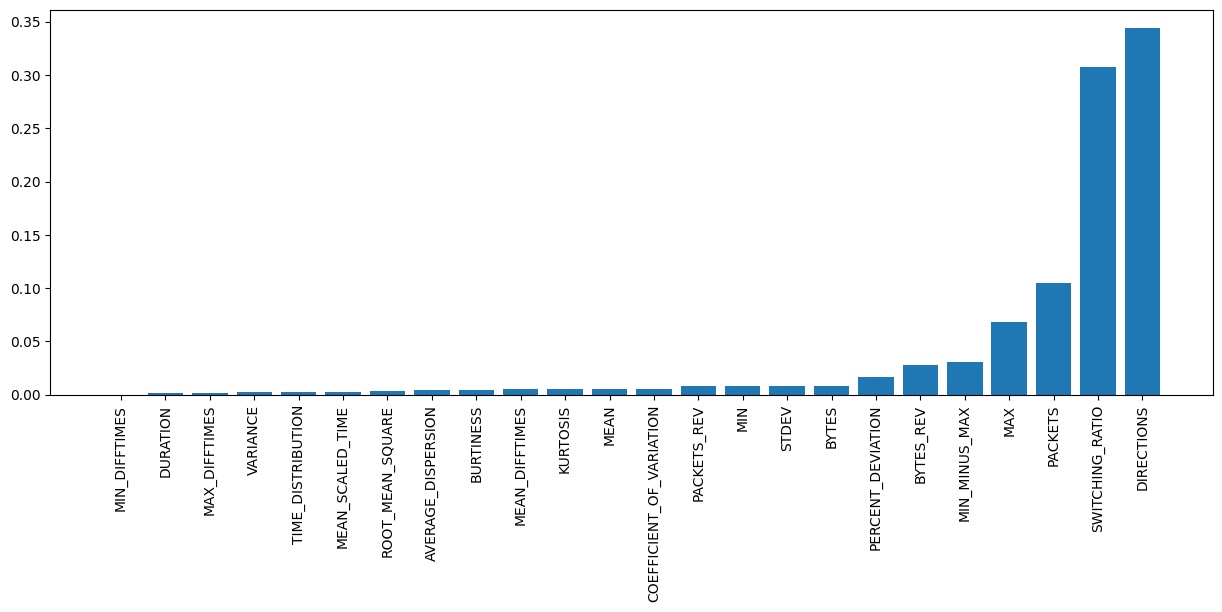

In [15]:
feat_importances = pd.Series(best_model.feature_importances_, index = X_validation.columns).sort_values(ascending = True)
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(feat_importances.keys(), feat_importances.values)
plt.xticks(rotation = 90)
plt.show()

In [13]:
feat_importances.to_dict()

{'MIN_DIFFTIMES': 0.0,
 'DURATION': 0.0012696030316874385,
 'MAX_DIFFTIMES': 0.001865658676251769,
 'VARIANCE': 0.002181191463023424,
 'TIME_DISTRIBUTION': 0.002259720116853714,
 'MEAN_SCALED_TIME': 0.002395143499597907,
 'ROOT_MEAN_SQUARE': 0.00321197253651917,
 'AVERAGE_DISPERSION': 0.004461247008293867,
 'BURTINESS': 0.004499373957514763,
 'MEAN_DIFFTIMES': 0.005152979400008917,
 'KURTOSIS': 0.005415756721049547,
 'MEAN': 0.005456822458654642,
 'COEFFICIENT_OF_VARIATION': 0.0055304476991295815,
 'PACKETS_REV': 0.007882893085479736,
 'MIN': 0.008033481426537037,
 'STDEV': 0.008135037496685982,
 'BYTES': 0.008182358928024769,
 'PERCENT_DEVIATION': 0.016438860446214676,
 'BYTES_REV': 0.028153875842690468,
 'MIN_MINUS_MAX': 0.03081224113702774,
 'MAX': 0.0686517134308815,
 'PACKETS': 0.10459986329078674,
 'SWITCHING_RATIO': 0.3072534501552582,
 'DIRECTIONS': 0.34400057792663574}